Setup enviroment

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.4.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q dgl

In [ ]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric import nn
import torch_geometric.transforms as T

In [ ]:
import json
import pandas as pd
import numpy as np
import random
import dgl
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load node2id dictionary

In [ ]:
os.path.isdir("/gpfs/gibbs/pi/gerstein/yc774/project/miRGD/graph")

True

In [ ]:
#open files
proj_dir = os.path.join("/gpfs/gibbs/pi/gerstein/yc774/project/miRGD/graph")
f = open(os.path.join(proj_dir,"node2id.json"))
node2id = json.load(f)

f = open(os.path.join(proj_dir,"id2node.json"))
id2node = json.load(f)

In [ ]:
relation = ["mm","dd","gg","md","mg","dg"]

edge_index = {}
for rel in relation:
  pth = os.path.join(proj_dir,"{}_edge.csv".format(rel))
  edge_df = pd.read_csv(pth)
  edge_list = np.transpose(edge_df.values)
  edge_index[rel] = torch.tensor(edge_list).long()

In [ ]:
edge_index

{'mm': tensor([[ 898,  898,  898,  ...,  694,  482,  482],
         [ 841, 1069,  541,  ...,  953, 1011,  147]]),
 'dd': tensor([[1175, 1175, 1175,  ..., 1134, 1134, 1134],
         [1180, 1144, 1208,  ..., 1168, 1141, 1139]]),
 'gg': tensor([[2147, 2147, 2147,  ..., 6556, 8910, 5385],
         [8388, 7092, 9807,  ..., 1735, 1735, 1735]]),
 'md': tensor([[ 898,  898,  898,  ...,  270,  946,  250],
         [1193, 1180, 1214,  ..., 1191, 1213, 1213]]),
 'mg': tensor([[  32,  832,  832,  ...,  589,  589,  100],
         [5215, 7835, 7835,  ..., 5135, 9328, 4016]]),
 'dg': tensor([[5925, 5925, 4194,  ..., 7342, 5467, 5467],
         [1183, 1153, 1153,  ..., 1204, 1131, 1148]])}

In [ ]:
node_list = node2id.values()

In [ ]:
from torch_geometric.data import Data
y = [1 for i in range(edge_index["md"].shape[0])]
data = Data(x=node_list, edge_index=edge_index["md"], y=y)
num_training_data =  edge_index["md"].shape[1]
x = edge_index["md"]

Split data for train/test

In [ ]:

import torch.utils.data as data
torch.manual_seed(0)
train_set_size = int(num_training_data* 0.75)
valid_set_size = int(num_training_data *0.05)
test_set_size = num_training_data - train_set_size - valid_set_size

index_list = np.arange(0,num_training_data,1)

np.random.shuffle(index_list)
training_data_index = index_list[:train_set_size]
validation_data_index  = index_list[train_set_size:train_set_size+valid_set_size]
testing_data_index = index_list[train_set_size+valid_set_size:]

train_x = []
train_y = []

valid_x = []
valid_y = []

test_x = []
test_y = []

#create training data
for idx in training_data_index:
  train_x.append([x[0][idx],x[1][idx]])
  train_y.append(1)
#create training data
for idx in validation_data_index:
  valid_x.append([x[0][idx],x[1][idx]])
  valid_y.append(1)
#create training data
for idx in testing_data_index:
  test_x.append([x[0][idx],x[1][idx]])
  test_y.append(1)

print("{} training data, {} validation data, {} testing data".\
  format(len(train_x), len(valid_x),len(test_x)))

train_mask = [0]*num_training_data
for i in training_data_index:
  train_mask[i] = 1


valid_mask = [0]*num_training_data
for i in validation_data_index:
  valid_mask[i] = 1

test_mask = [0]*num_training_data
for i in testing_data_index:
  test_mask[i] = 1

2999 training data, 199 validation data, 801 testing data


Negative sampling

In [ ]:
all_edges = np.column_stack((edge_index["mm"], edge_index["dd"],edge_index["gg"],\
                             edge_index["md"],edge_index["mg"],edge_index["dg"]))

import random

num_neg = 50000
neg_edge_index =  []
edge_trans = np.transpose(edge_index["mg"])
while len(neg_edge_index) < num_neg:
  m = random.randint(0, 1109)
  d = random.randint(1109, 1222)

  if torch.tensor([m,d]) not in edge_trans:
    neg_edge_index.append([m,d])

#print("numer of neg_edge_index:", len(neg_edge_index))  # [2, num_neg_samples]
#print("negative examples:", neg_edge_index)

Create train valid test mask

In [ ]:
edge_index_masked = edge_index
edge_index_md = edge_index_masked["md"]
edge_index_md_train_masked = list(zip(np.transpose(edge_index_md),train_mask))
edge_index_md_valid_masked = list(zip(np.transpose(edge_index_md),valid_mask))
edge_index_md_test_masked= list(zip(np.transpose(edge_index_md),test_mask))

edge_index_md_train_masked = [x[0].tolist() for x in edge_index_md_train_masked if x[1] == 1]
edge_index_md_valid_masked = [x[0].tolist() for x in edge_index_md_valid_masked if x[1] == 1]
edge_index_md_test_masked = [x[0].tolist() for x in edge_index_md_test_masked if x[1] == 1]

edge_index_train = edge_index_masked
edge_index_train["md"] = torch.tensor(np.transpose(edge_index_md_train_masked))

edge_index_valid = edge_index_masked
edge_index_valid["md"] = torch.tensor(np.transpose(edge_index_md_valid_masked))

edge_index_test = edge_index_masked
edge_index_test["md"] = torch.tensor(np.transpose(edge_index_md_test_masked))

Random initialize node features

In [ ]:
n_features = 32
node_features = torch.rand((len(node_list), n_features),dtype=torch.double)
node_features = torch.unsqueeze(node_features, dim=-1).double()
node_features = torch.from_numpy(np.random.randint(100, size = (len(node_list),n_features) )).float()

In [ ]:
node_features.shape

torch.Size([10532, 32])

Link Prediction - Random Feature

In [ ]:
from torch_geometric.nn import GCNConv

class GCN_RandFeature(torch.nn.Module):
    def __init__(self, num_node, edge_list, relations, hidden_channels, out_channels):
        super().__init__()

        # self.E = torch.rand(num_node, E_dim)
        self.edges = edge_list
        self.relarions = relations
        self.num_relarion = len(self.relarions)

        self.conv1 = [GCNConv(32, hidden_channels) for i in range(self.num_relarion)]
        self.transform1 = torch.nn.Linear(hidden_channels*6,hidden_channels)
        self.conv2 = [GCNConv(hidden_channels, hidden_channels) for i in range(self.num_relarion)]
        self.transform2 = torch.nn.Linear(hidden_channels*6,out_channels)
        self.act = torch.nn.ReLU()

        self.ff1 = torch.nn.Linear(out_channels*2,32)
        self.ff2 = torch.nn.Linear(32,1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,edge_list,node_features):
        out1 = []
        for i,rel in enumerate(self.relarions):
          out1.append(self.conv1[i](node_features, edge_list[rel]))

        out = torch.cat(out1, 1)
        out = self.transform1(out)

        out = self.act(out)

        out2 = []
        for i,rel in enumerate(self.relarions):
          out2.append(self.conv2[i](out, self.edges[rel]))

        out = torch.cat(out2, 1)
        out = self.transform2(out)

        return out

    def classifier1(self, node_pair):

        node1 = node_pair[0]
        node2 = node_pair[1]
        x =  torch.cat((node1,node2))

        x = self.ff1(x)
        x = self.ff2(x)
        output = self.sigmoid(x)

        return output

    def classifier2(self, node_pairs):
        node1 = self.E[node_pair[0]]
        node2 = self.E[node_pair[1]]

        x =  torch.cat((node1,node2))
        x = self.ff1(x)
        x = self.ff2(x)
        output = self.sigmoid(x)

        return output

from tqdm import tqdm
from torch.autograd import Variable
# train with all class of relations
def train2(model, data, node_features, neg_edge_index, optimizer, loss_fn,train_mask):
  loss = 0
  model.train()
  optimizer.zero_grad()

  node_embs = model(data,node_features)

  y_pred = []


  neg_edge_index = torch.tensor(neg_edge_index)

  data = data["md"]
  data = np.transpose(data)


  all_data = torch.cat((data,neg_edge_index),0)
  all_labels = torch.tensor([1]*len(data)+[0]*len(neg_edge_index))
  #for test purpose, comment out after
  # all_data = all_data[:10]
  # all_labels = all_labels[:10]
  # for idx, pair in tqdm(enumerate(all_data)):
  #     pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
  #     y_pred.append(model.classifier1(pair_embed))
  for idx, pair in enumerate(tqdm(all_data)):
      pair_embed = (node_embs[pair[0]],node_embs[pair[1]])
      y_pred.append(model.classifier1(pair_embed))


  # y_pred = Variable(y_pred, requires_grad=True)
  # print(y_pred.shape)

  y_pred = torch.tensor(y_pred)
  loss = loss_fn(y_pred,all_labels.float())
  # loss = torch.tensor(loss)
  # outputs.clone().detach()
  loss = Variable(loss, requires_grad=True)
  loss.backward()
  optimizer.step()

  return loss

from sklearn.metrics import accuracy_score

@torch.no_grad()
def test2(model, data,node_features):
    model.eval()
    out = model(data,node_features)

    data = data["md"]
    data = np.transpose(data)
    y_pred = []
    for idx, pair in enumerate(tqdm(data)):
      pair_embed = (out[pair[0]],out[pair[1]])
      y_pred.append(model.classifier1(pair_embed))
    y_pred = [1 if y>0.5 else 0 for y in y_pred]

    return accuracy_score([1]*len(y_pred), y_pred)
model = GCN_RandFeature(len(node_list), \
            edge_list =edge_index, \
            relations = relation,  \
            hidden_channels=128, \
            out_channels=64)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()

epochs = 10
all_train_loss = []
all_valid_loss = []
all_valid_accu = []
all_test_accu = []

best_val_accu = final_test_accu = 0
for epoch in range(1, epochs + 1):
    train_loss = train2(model, edge_index_train, node_features,neg_edge_index, optimizer, loss_fn, train_mask)
    valid_loss = train2(model, edge_index_valid, node_features,neg_edge_index, optimizer, loss_fn, valid_mask)
    valid_accu = test2(model, edge_index_valid,node_features)
    test_accu = test2(model, edge_index_test,node_features)
    all_train_loss.append(train_loss.detach().numpy())
    all_valid_loss.append(valid_loss.detach().numpy())
    all_valid_accu.append(valid_accu)
    all_test_accu.append(test_accu)

    if valid_accu > best_val_accu:
        best_val_accu = valid_accu
        final_test_accu = test_accu
    print(f'Epoch: {epoch:03d}, trainLoss: {train_loss:.4f}, trainLoss: {valid_loss:.4f},ValAccu: {valid_accu:.4f}, TestAccu: {test_accu:.4f}')

100%|██████████| 801/801 [00:00<00:00, 9395.48it/s]


Epoch: 001, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9469.42it/s]


Epoch: 002, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9421.23it/s]


Epoch: 003, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9312.82it/s]


Epoch: 004, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9409.48it/s]


Epoch: 005, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9002.70it/s]


Epoch: 006, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9475.24it/s]


Epoch: 007, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9473.69it/s]


Epoch: 008, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9388.03it/s]


Epoch: 009, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


100%|██████████| 801/801 [00:00<00:00, 9354.67it/s]

Epoch: 010, trainLoss: 1.2748, trainLoss: 1.2748,ValAccu: 0.9750, TestAccu: 0.9750


In [ ]:
def plot_train_valid_loss(epochs,train_loss,valid_loss):
  epoch = list(range(epochs))
  # plotting the line 1 points
  plt.plot(epoch, train_loss, label = "train")
  plt.plot(epoch, valid_loss, label = "valid")

  # naming the x axis
  plt.xlabel('epochs')
  # naming the y axis
  plt.ylabel('loss')
  # giving a title to my graph
  plt.title('train valid loss')
  # show a legend on the plot
  plt.legend()
  plt.show()

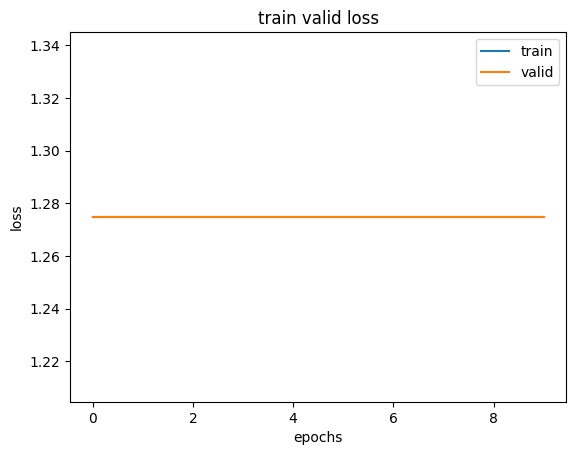

In [ ]:
plot_train_valid_loss(epochs,all_train_loss,all_valid_loss)